Imports + initialize tpu/gpu

In [1]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    GCS_PATH = 'gs://kds-730dfb73e90bcfe94bba623cbc90984df476fa507c3e44b785ea223e/'
except:
    print('WARNING: Not connected to a TPU runtime')
    strategy = tf.distribute.get_strategy()
    GCS_PATH = ''

Import Pneumonia Dataset (from google store for tpu) + set variables (batch, epoch, image size, tune)

In [2]:
filenames = tf.io.gfile.glob(str(GCS_PATH + 'chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + 'chest_xray/val/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 224
EPOCHS = 15

Functions for processing images

In [3]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use buffered prefetching so we can yield data from disk without having I/O blocking

In [4]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Load + Process train/test data

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(train_filenames)).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(val_filenames)).numpy()

In [6]:
test_ds = tf.data.Dataset.list_files(str(GCS_PATH + 'chest_xray/test/*/*')).map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

train_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(train_filenames).map(process_path, num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(val_filenames).map(process_path, num_parallel_calls=AUTOTUNE))

image_batch, label_batch = next(iter(train_ds))

2022-03-02 18:56:54.858041: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-02 18:56:57.054990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Data was imbalanced, with more images classified as pneumonia than normal. Each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

In [7]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Retrain moblenetv2 model for use with dataset (transfer learning).

Since there are only two possible labels for the image, we will be using the `binary_crossentropy` loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    base_model.trainable = False
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1),
    ])
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=int((EPOCHS/3)*2),
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/20
261/261 [==============================] - 42s 149ms/step - loss: 2.0992 - accuracy: 0.7965 - val_loss: 0.5116 - val_accuracy: 0.9375
Epoch 2/20
261/261 [==============================] - 32s 123ms/step - loss: 0.8322 - accuracy: 0.8946 - val_loss: 0.5613 - val_accuracy: 0.9317
Epoch 3/20
261/261 [==============================] - 30s 117ms/step - loss: 0.8898 - accuracy: 0.9097 - val_loss: 0.5547 - val_accuracy: 0.9462
Epoch 4/20
261/261 [==============================] - 31s 120ms/step - loss: 6.4173 - accuracy: 0.3815 - val_loss: 11.2572 - val_accuracy: 0.2702
Epoch 5/20
261/261 [==============================] - 30s 115ms/step - loss: 7.7068 - accuracy: 0.2555 - val_loss: 11.2572 - val_accuracy: 0.2702
Epoch 6/20
261/261 [==============================] - 30s 115ms/step - loss: 7.7142 - accuracy: 0.2548 - val_loss: 11.2721 - val_accuracy: 0.2692
Epoch 7/20
 49/261 [====>.........................] - ETA: 19s - loss: 7.6318 - accuracy: 0.2628

In [9]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 20/30
261/261 [==============================] - 49s 184ms/step - loss: 7.6267 - accuracy: 0.7450 - val_loss: 1.0343 - val_accuracy: 0.9019
Epoch 21/30
261/261 [==============================] - 48s 184ms/step - loss: 7.6196 - accuracy: 0.7452 - val_loss: 1.9674 - val_accuracy: 0.8433
Epoch 22/30
261/261 [==============================] - 49s 187ms/step - loss: 7.6411 - accuracy: 0.7445 - val_loss: 2.9869 - val_accuracy: 0.7827
Epoch 23/30
261/261 [==============================] - 52s 199ms/step - loss: 7.6124 - accuracy: 0.7455 - val_loss: 3.7180 - val_accuracy: 0.7500
Epoch 24/30
261/261 [==============================] - 60s 229ms/step - loss: 7.6411 - accuracy: 0.7445 - val_loss: 4.0380 - val_accuracy: 0.7317
Epoch 25/30
261/261 [==============================] - 52s 199ms/step - loss: 7.5838 - accuracy: 0.7464 - val_loss: 4.1202 - val_accuracy: 0.7298
Epoch 26/30
261/261 [==============================] - 50s 190ms/step - loss: 7.6339 - accuracy: 0.7447 - val_loss: 4.0909 -

Plot Results

Text(0.5, 1.0, 'Training and Validation Accuracy')

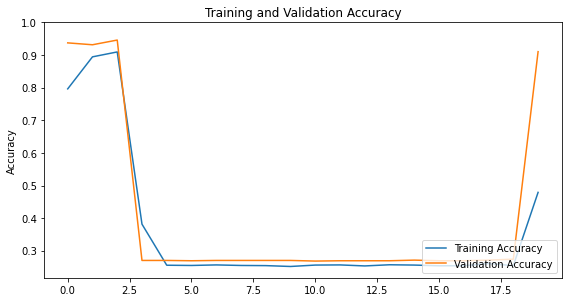

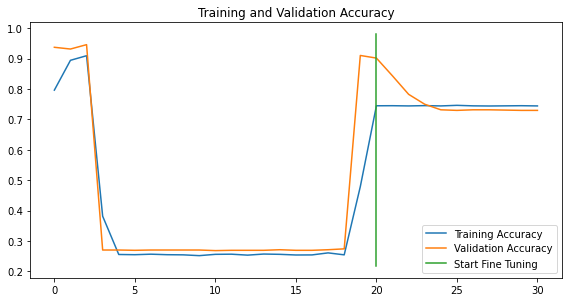

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([int((EPOCHS/3)*2),int((EPOCHS/3)*2)],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Convert model to TFLite

In [12]:
def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files(GCS_PATH + "chest_xray/train/*/*")
    for i in range(100):
        path = next(iter(dataset_list))
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_jpeg(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0 
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.expand_dims(img, 0)
        yield [img]
        
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

with open('xray_mobilenetv2_quant_model.tflite', 'wb') as f:
    f.write(tflite_model_quant)
    
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
output_type = interpreter.get_output_details()[0]['dtype']
print('input: ', input_type)
print('output: ', output_type)

labels = ['PNEUMONIA', 'NORMAL']
with open('xray_labels.txt', 'w') as f:
    for line in labels:
        f.write(line)
        f.write('\n')

INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpnits08y6/assets


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpnits08y6/assets
/Users/shauryasingh/miniforge3/envs/edgetpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-03-02 19:18:54.780785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-02 19:18:54.780799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-02 19:18:54.780872: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpnits08y6
2022-03-02 19:18:54.796083: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-02 19:18:54.796097: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel d

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler
!sudo apt-get install edgetpu-examples
!edgetpu_compiler xray_mobilenetv2_quant_model.tflite

Connect Coral USB Accelerator before running this code. Run `sudo apt-get install edgetpu-examples` if you haven't already

In [ ]:
from edgetpu.classification.engine import ClassificationEngine
from edgetpu.utils import dataset_utils
from PIL import Image

labels = dataset_utils.read_label_file('xray_labels.txt')
engine = ClassificationEngine('xray_mobilenetv2_quant_model_edgetpu.tflite')

# Run inference.
img = Image.open('chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')
for result in engine.classify_with_image(img, top_k=3):
 print('---------------------------')
 print(labels[result[0]])
 print('Score : ', result[1])

img = Image.open('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg')
for result in engine.classify_with_image(img, top_k=3):
 print('---------------------------')
 print(labels[result[0]])
 print('Score : ', result[1])